# Project: Spaceship Titanic

In this project our task is to predict whether a passenger was transported  
to an alternate dimension during the Spaceship Titanic's collision with  
the spacetime anomaly. To help make these predictions, we are given a set of  
personal records recovered from the ship's damaged computer system

#### Libraries that will be used in project

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import scipy.stats as stats
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
# Path to train and test files
path_train = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint3\project\train.csv"
path_test = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint3\project\test.csv"

# Get panda's dataframe and shape
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
print(f"Train df shape: {train.shape}")
print(f"Test df shape: {test.shape}")

Train df shape: (8693, 14)
Test df shape: (4277, 13)


In [3]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


We shall look at basic structure of dataframe

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


There are 3 data types: object(7), float(6) and boolean (target). 13 columns of  
features and 1 target named "Transported"

---
## Data cleaning

*For the following steps of data cleaning: data will be cleaned only for train  
df but every change in dataframe (columns, labels, etc.) will be added for test  
df when latter is used*

First of all let's make all letters in columns labels to lower case, remove  
empty spaces in order to simplicity and convenience. Also check for duplicates,  
NaN numbers and empty cells

In [6]:
train_df = sand.cleaner(train)

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: False
Is there any NaN numbers?: True
Is there any empty cells?: False


Function says that there are some NaNs in df. These must be evaluated and  
fixed. Firstly, we need to find which features have NaNs

In [7]:
nans = train_df.isna().sum()
percentage = (nans / len(train_df)) * 100
pd.DataFrame({"nan_count": nans, "perentage(%)": round(percentage, 2)})

,nan_count,perentage(%)
passengerid,0,0.00
homeplanet,201,2.31
cryosleep,217,2.50
cabin,199,2.29
destination,182,2.09
age,179,2.06
vip,203,2.34
roomservice,181,2.08
foodcourt,183,2.11
shoppingmall,208,2.39


Most of features on average have ~2% NaNs. We need to fill  empty spaces (NaNs)  
of each column. To fill numeric values, I am using mean value of column and for  
categorical - imputation methon with SimpleIputer function 

In [8]:
# create imputer variables for numeric and categoric features
numerical_imp = SimpleImputer(strategy="mean")
categorical_imp = SimpleImputer(strategy="most_frequent")
numericals = ["age", "roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck"]
categoricals = ["homeplanet", "cryosleep", "cabin", "destination", "vip", "name"]

# fill empty cells using imputation method
train_df[numericals] = numerical_imp.fit_transform(train_df[numericals])
train_df[categoricals] = categorical_imp.fit_transform(train_df[categoricals])

train_df.isna().any().any()
# Issiaiskinti ar tikrai galima fillinti cabin su most frequent nes keista
# kai random toje pacioje kabinoje skirtingi zmones butu???????

False

As we can see from function .any().any() there are no NaNs left meaning we  
successfully filled empty cells

Now we can check numeric values with .describe() to look deeper in numeric  
data

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8693.0,28.827930,14.339054,0.0,20.0,27.0,37.0,79.0
roomservice,8693.0,224.687617,659.739364,0.0,0.0,0.0,78.0,14327.0
foodcourt,8693.0,458.077203,1594.434978,0.0,0.0,0.0,118.0,29813.0
shoppingmall,8693.0,173.729169,597.417440,0.0,0.0,0.0,45.0,23492.0
spa,8693.0,311.138778,1124.675871,0.0,0.0,0.0,89.0,22408.0
vrdeck,8693.0,304.854791,1133.259049,0.0,0.0,0.0,71.0,24133.0


We can see that all of numeric features have relatively high values in mean and  
even higher in std. Since float type is usually used for smaller numbers or  
strong accuracy, with these numbers float doesn't has huge impact and it could  
be converted to integer. Age feature is usually written in int dtype and can be  
converted too

In [10]:
# converting from float to int
train_df[numericals] = train_df[numericals].astype(int)

---
## Exploratory Data Analysis (EDA)

Since dataset has been fairly cleaned, some insights could be looked for to  
get deeper view. Firstly, we can check our main project's target  
feature - Transported 

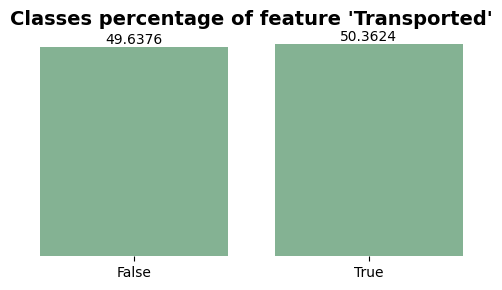

In [11]:
sand.f_countplot(
    data=train_df, 
    xaxis="transported",
    stat="percent", 
    title="Classes percentage of feature 'Transported'"
)

As we can see from plot, both values percent are very similar showing strong  
indicator of strongly balanced classes. This  could be benefit on ML modeling  
part

#### Numeric data

We can look at distribution of age combined with hued target

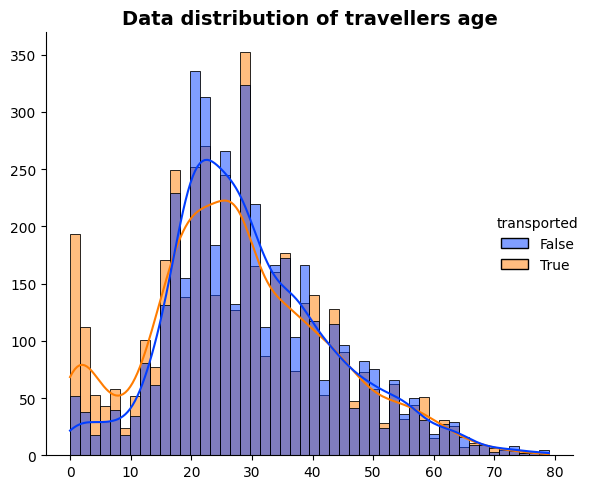

In [12]:
sand.f_displot(
    data=train_df,
    xaxis="age",
    hue="transported",
    palette="bright",
    kde=True,
    title="Data distribution of travellers age"
)

From distribution plot we can see that data isn't normally distributed. People  
0-15 age were more likely to be transported. Most of the travellers were on  
age interval 20-30 as well as higher number of which weren't transported. From  
age 40 to 80 transported and untransported people count was fairly similar

We can look at other continuous numeric features too

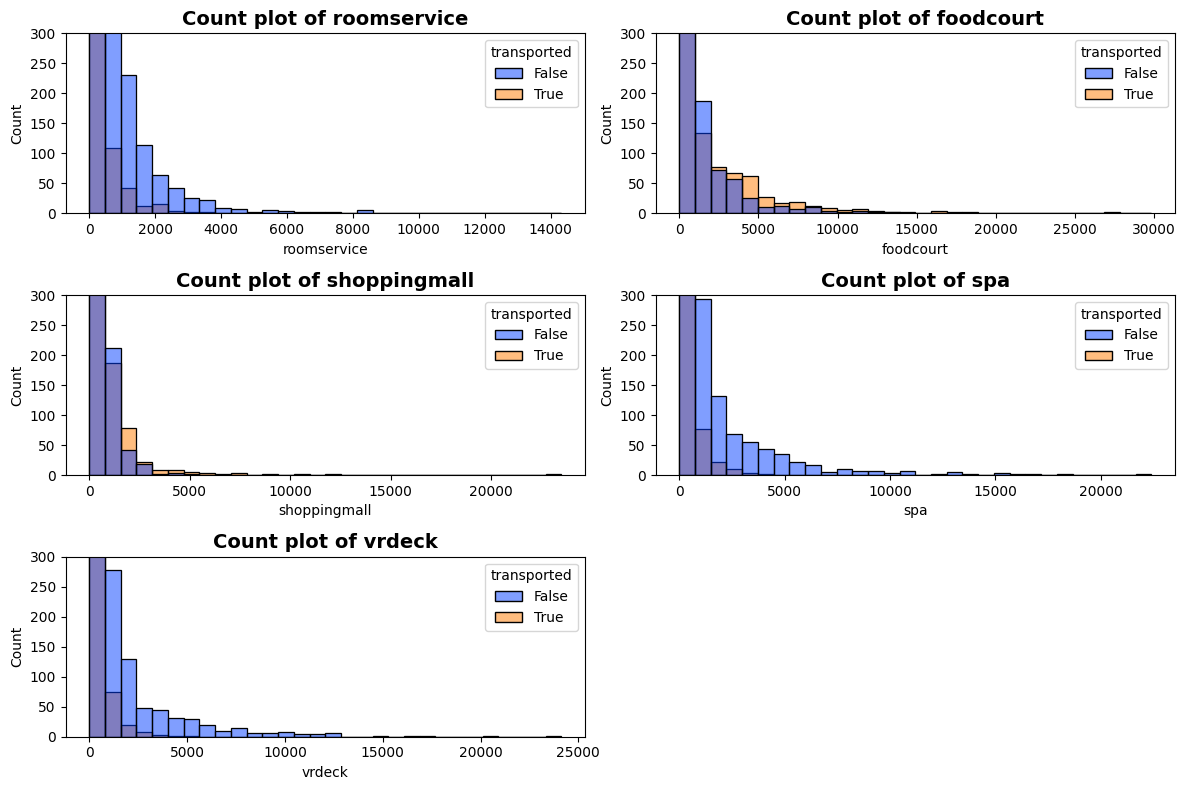

In [13]:
def num_mult(df):
    multiple_numeric = ["roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck"]
    fig, ax = plt.subplots(3, 2, figsize=(12, 8))
    ax = ax.flatten()
    for i, col in enumerate(multiple_numeric):
        sns.histplot(data=df, x=col, bins=30, ax=ax[i], palette="bright", hue="transported")
        ax[i].set_title(f"Count plot of {col}", size=14, fontweight="bold", ha="center")
        ax[i].set_ylim(top=300)
    if len(multiple_numeric) < len(ax):
        fig.delaxes(ax[-1])
    plt.tight_layout()

    plt.show()
num_mult(train_df)

From these plots we can take some of insights:  
- Most of the data for each service are 0 or near it  
- With increasing money spend, amount of count drops dramatically  
- It can be said that increased money spend to spa, foodcourt or other service  
doesn't increase possibility to be transported
- It is important to say that highly skewed data can affect the performance of  
ML models. Here we have 5 highly skewed to the right features with long tails.  
This problem could be mitigated by applying transformation technique to make  
data more symetric. To our data it will be benefit to use Log transformation  
due to long data tails. We will tranform in feature engineering part

#### Categorical data

Now take a look at categorical data. I didn't included here PassengerId,  
Name since these features doesn't have impact to analysis quality. Also, for  
this moment I excluded feature named Cabin, because I will transform this  
feature into more usable and informative on feature engineering part

In [14]:
cat = ["homeplanet", "cryosleep", "destination", "vip", "name"]
train_df[cat].nunique()

homeplanet        3
cryosleep         2
destination       3
vip               2
name           8473
dtype: int64

We have 3 home planets, 2 different cryosleep classes, 3 destinations, 2 vips  
and many different names. We can look how these are distributed

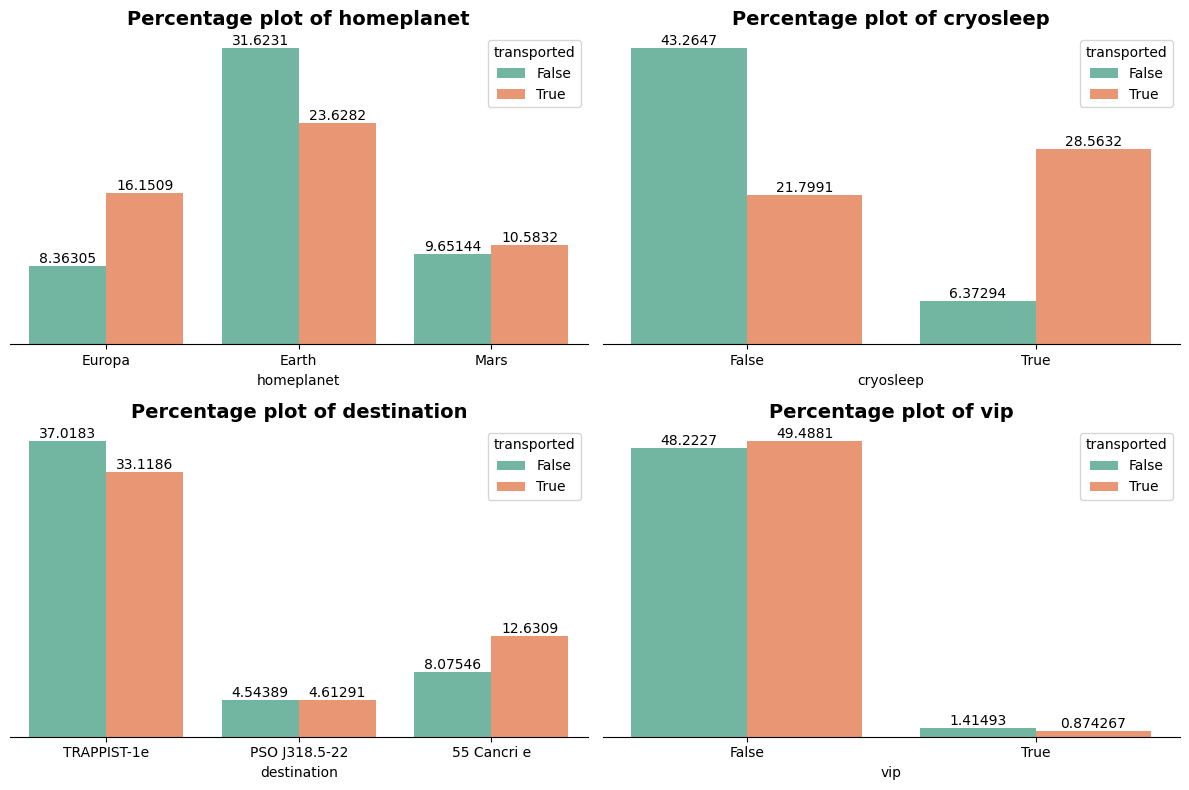

In [15]:
categorics = train_df[cat].drop(columns=["name"])
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
for axis, col in zip(ax, list(categorics.columns)):
    sns.countplot(
        data=categorics,
        x=col,
        ax=axis,
        hue=train_df["transported"],
        stat="percent",
        palette="Set2",
    )
    for container in axis.containers:
        axis.bar_label(container, padding=0)
    axis.axes.get_yaxis().set_visible(False)
    axis.axes.get_xaxis().set_visible(True)
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.spines["left"].set_visible(False)
    axis.set_xlabel(col)
    axis.set_ylabel("Count")
    axis.set_title(f"Percentage plot of {col}", size=14, fontweight="bold", ha="center")
if len(list(categorics.columns)) < len(ax):
    fig.delaxes(ax[-1])
plt.tight_layout()

plt.show()

From these plots we can see interesting data:  
- Most of the people are from planet Earth. People whose home planet is Europa,  
transported count is two times more
- More people tend not to use cryosleep but those who chose, almost 5 times  
more were transported
- About 70% of travellers destination was "TRAPPIST-1e". Target's class balance  
is similar to all 3 destinations. Only "55 Cancri e" difference is a little  
higher
- About 2% of travellers chose VIP but it didn't increase possibility to be  
transported as bars show
- Homeplanet and Cryosleep could be very useful features for modelling while  
VIP doesn't have almost any possitive impact for ML 

---
## Feature engineering

Now we can engineer more features from current ones to increase different point  
of views for model to decide

Let's make 4 classes for new feature age_cl

In [16]:
train_df["age_cl"] = 0
train_df["age_cl"] = np.where(
    train_df["age"] <= 10,
    "0-10",
    np.where(
        train_df["age"] <= 20,
        "11-20",
        np.where(
            train_df["age"] <= 30,
            "21-30",
            np.where(
                train_df["age"] <= 40,
                "31-40",
                np.where(train_df["age"] <= 50, "41-50", "50+"),
            ),
        ),
    ),
)
train_df.drop(columns=["age"], inplace=True)
train_df["age_cl"].unique()

array(['31-40', '21-30', '50+', '11-20', '41-50', '0-10'], dtype=object)

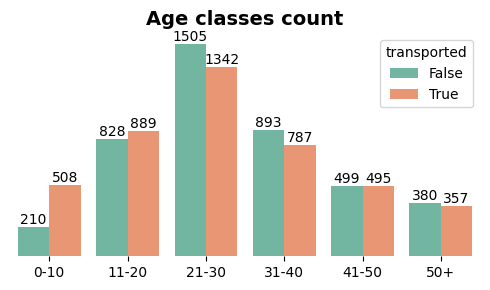

In [17]:
order = ["0-10", "11-20", "21-30", "31-40", "41-50", "50+"]
sand.f_countplot(
    data=train_df,
    xaxis="age_cl",
    hue="transported",
    title="Age classes count",
    palette="Set2",
    order=order,
)

From new class we can see that more than half people were transported of class  
"age_0-10" as well as slightly more in group 11-20, meaning that children was  
priority to save. Other classes have less numbers of transported people

In [18]:
train_df.head(3)

,passengerid,homeplanet,cryosleep,cabin,destination,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,age_cl
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0,0,0,0,0,Maham Ofracculy,False,31-40
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109,9,25,549,44,Juanna Vines,True,21-30
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43,3576,0,6715,49,Altark Susent,False,50+


As I mentioned before, I've left feature cabin for transformation. We will make  
3 new features: deck, cabin_num, side. This transformation should be useful  
because it might show new isights of data

In [19]:
train_new = train_df.copy()

# column split to 3 new columns
split_df = train_df["cabin"].str.split("/", expand=True)
split_df.columns = ["cabindeck", "cabinnum", "cabinside"]

# join two dataframes to one
train_new = pd.concat([train_df, split_df], axis=1)
train_new.drop(columns=["cabin"], inplace=True)
train_new.head(3)

,passengerid,homeplanet,cryosleep,destination,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,age_cl,cabindeck,cabinnum,cabinside
0,0001_01,Europa,False,TRAPPIST-1e,False,0,0,0,0,0,Maham Ofracculy,False,31-40,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,False,109,9,25,549,44,Juanna Vines,True,21-30,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,True,43,3576,0,6715,49,Altark Susent,False,50+,A,0,S


In [20]:
train_new["cabinnum"] = train_new["cabinnum"].astype(int)

Herein we added 3 new columns. Also, I changed cabin_num dtype from object  
to integer. Now we can see how new data looks

In [21]:
# Count unique values in each column
for i in ["cabindeck", "cabinnum", "cabinside"]:
    print(f"We have unique {i}: {train_new[i].nunique()}")

We have unique cabindeck: 8
We have unique cabinnum: 1817
We have unique cabinside: 2


Let's look travellers choice for cabins and as well VIP people per cabin

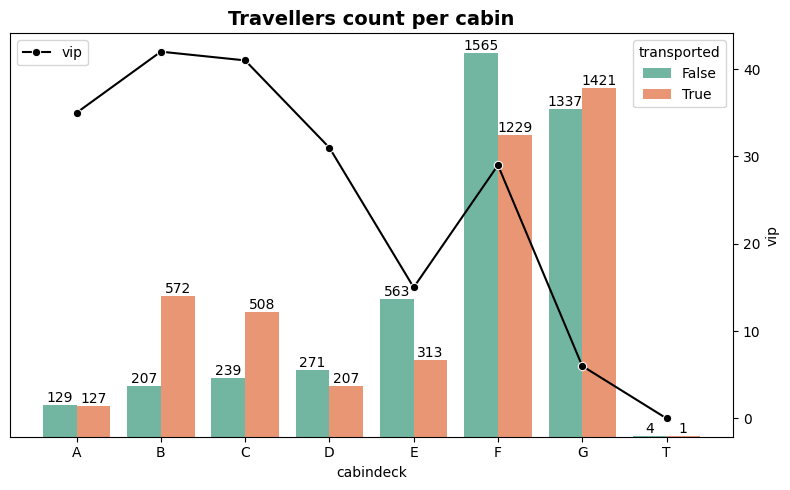

In [22]:
plt.figure(figsize=(8, 5))
cdeck_ord = sorted(train_new["cabindeck"].unique())
cnt = sns.countplot(
    data=train_new, x="cabindeck", hue="transported", palette="Set2", order=cdeck_ord
)
for container in cnt.containers:
    cnt.bar_label(container)
cnt.axes.get_yaxis().set_visible(False)
cnt.axes.get_xaxis().set_visible(True)
cnt.set_frame_on(False)
plt.title("Travellers count per cabin", size=14, fontweight="bold", ha="center")

lin = sns.lineplot(data=train_new, x="cabindeck", y="vip", ax=cnt.twinx(), label="vip", marker="o", color="black", errorbar=None, estimator="sum")
lin.legend(loc="upper left")
plt.tight_layout()
plt.show()

We can see that most popular cabins are "F" and "G" class. These might be  
most affordable. Also, two times more travellers were transported from "B" and  
"C" cabins. By looking at vip traveller line, we can see that highest number  
of vips are at A-D cabins where B is the most vips holding cabin

In [23]:
from sklearn.preprocessing import LabelEncoder

cats = train_new.select_dtypes(include=["object"])
le = LabelEncoder()
train_new_encoded = train_new.copy()
for col in cats.columns:
    train_new_encoded[col] = le.fit_transform(train_new_encoded[col])

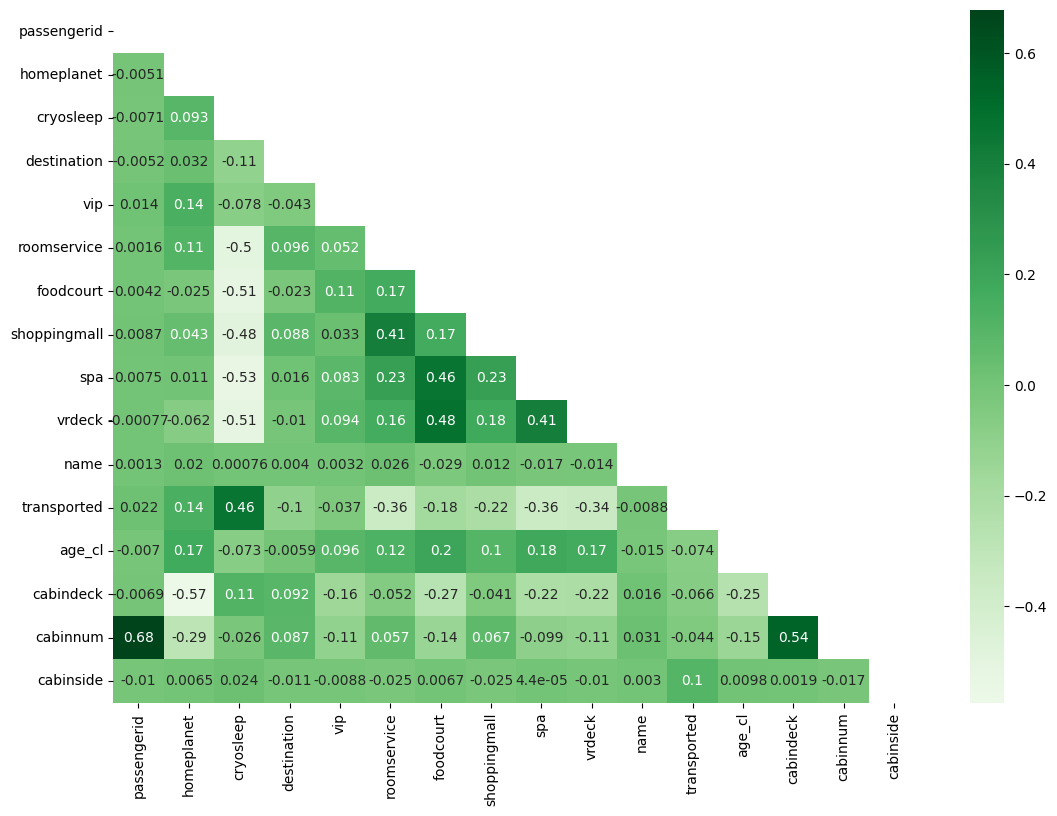

In [24]:
spearmans_corr = train_new_encoded.corr(method="spearman")
sand.f_heatmap(spearmans_corr, figsize=(13, 9))

As mentioned at the numeric data EDA part, we have very skewed data which  
could be tranformed using Log transformation to increase ML models performance

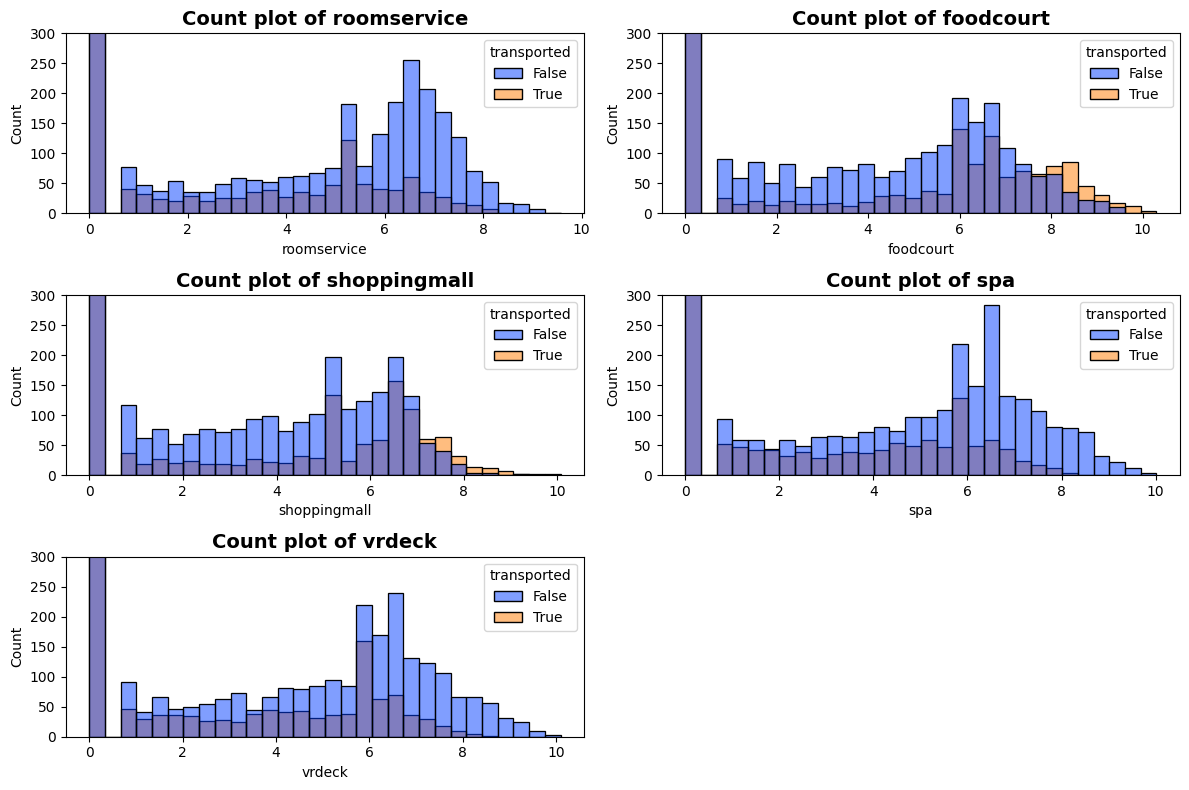

In [25]:
train_new["roomservice"] = np.log1p(train_new["roomservice"])
train_new["foodcourt"] = np.log1p(train_new["foodcourt"])
train_new["shoppingmall"] = np.log1p(train_new["shoppingmall"])
train_new["spa"] = np.log1p(train_new["spa"])
train_new["vrdeck"] = np.log1p(train_new["vrdeck"])
num_mult(train_new)

As we can see, there are less skewness in plots which should help ML models  
to increase performance at the end 

---
## Other insights

I will check categorical features degree of dependency on target variable by  
using mutual info score function. Higher values means higher dependency. It  
implies that we can get better prediction on target variable

In [26]:
categoricals = train_new.select_dtypes(include=["object"])
def cat_mut_inf(series):
    return mutual_info_score(series, train_new["transported"])

scores_cat = categoricals.apply(cat_mut_inf)
scores_cat = (scores_cat
              .sort_values(ascending=False)
              .to_frame(name="mutual_info_score"))
scores_cat

,mutual_info_score
passengerid,0.693121
name,0.675740
cryosleep,0.112254
cabindeck,0.023149
homeplanet,0.018581
age_cl,0.008396
destination,0.006113
cabinside,0.005149
vip,0.000700


We can see that passengerid and name have strong impact to our target feature.  
Third place is cryosleep. These features could be used for further  
investigation

We can also check multicollinearity of numeric features using Variance  
Inflation Factor (VIF). Having VIF > 10 suggests there is high correlation with  
other features. This would help us decrease redundancy of features

In [27]:
numericals = train_new.select_dtypes(include=["number"])
sand.calc_vif(numericals)

,variables,VIF
1,foodcourt,1.931906
3,spa,1.860109
4,vrdeck,1.835190
2,shoppingmall,1.627674
0,roomservice,1.627621
5,cabinnum,1.445908


By having small VIF factors (< 3) we can be assure that numeric features does  
not correlate between each other. It helps to prevent from reduced model  
interpretability or increaced variance

---
  ## ML modeling

#### Preprocessing

For machine learning modeling part firstly, we will preprocess our prepared  
data so it could be correctly used in machine models

In [28]:
train_new.head(3)

,passengerid,homeplanet,cryosleep,destination,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,age_cl,cabindeck,cabinnum,cabinside
0,0001_01,Europa,False,TRAPPIST-1e,False,0.00000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,31-40,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,False,4.70048,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True,21-30,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,True,3.78419,8.182280,0.000000,8.812248,3.912023,Altark Susent,False,50+,A,0,S


In [29]:
# Prediction target(y) and features (X)
X = train_new.drop(columns="transported", axis=1)
y = train_new["transported"]

# Numerical and categorical variables
nums = ["roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck", "cabinnum"]
cats = [
    "passengerid",
    "homeplanet",
    "cryosleep",
    "destination",
    "vip",
    "name",
    "age_cl",
    "cabindeck",
    "cabinside",
]

# Numeric and categoric features preprocessors
cats_preprocessor = OneHotEncoder(handle_unknown="ignore")
nums_preprocessor = StandardScaler()

# Create column transformer for the pipeline
preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", cats_preprocessor, cats),
        ("standard_scaler", nums_preprocessor, nums),
    ]
)

# Train/test data splitting
data_train, data_test, target_train, target_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

We have prepared our data to be preprocessed by different preprocessors for  
numeric and categoric types. Also, data was splitted for training and testing  
with the ratio of 70/30 where is about 1700 data points for testing

#### Model selection

At this part we will select 5 models to work with:  
KNN, Logistic Regression, SVC, Random Forest, XGBoost

In [31]:
# Dictionary for models to be selected
models = {
    "KNN":KNeighborsClassifier(),
    "Logistic Regression":LogisticRegression(max_iter=500),
    "SVC":SVC(),
    "Random Forest":RandomForestClassifier(),
    "XGBoost":XGBClassifier()
}

# scores_df = pd.DataFrame({"model_name":[], "score":[], "cv_score":[], "prediction_score":[], "recall_score":[], "f1_score":[]})

# Iteration through each model
for model_name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    _ = pipeline.fit(data_train, target_train)
    target_predicted = pipeline.predict(data_test)

    # Cross-validation score
    score = cross_validate(pipeline, data_train, target_train, cv=5)

    # Results
    print(f"Model name: {model_name}")
    print(f"Score: {pipeline.score(data_test, target_test)}")
    print(f"CV score: {score['test_score'].mean():.3f} +- {score['test_score'].std()}")
    print(f"{sand.model_result_calc(target_test, target_predicted, pos_label=0)}\n")


Model name: KNN
Score: 0.7521564117308798
CV score: 0.763 +- 0.009988696839514323
Precision score: 0.74
Recall score: 0.77
F1 score: 0.75
None

Model name: Logistic Regression
Score: 0.772857964347326
CV score: 0.779 +- 0.011197089592567306
Precision score: 0.77
Recall score: 0.77
F1 score: 0.77
None

Model name: SVC
Score: 0.7924094307073031
CV score: 0.807 +- 0.008522825430984328
Precision score: 0.81
Recall score: 0.75
F1 score: 0.78
None

Model name: Random Forest
Score: 0.7906843013225991
CV score: 0.794 +- 0.00634189873663105
Precision score: 0.78
Recall score: 0.81
F1 score: 0.79
None

Model name: XGBoost
Score: 0.7958596894767107
CV score: 0.804 +- 0.00490600988808702
Precision score: 0.78
Recall score: 0.81
F1 score: 0.80
None



Based on the results, XGBoost and SVC have the highest overall performance,  
with XGBoost slightly outperforming the others in terms of F1 score (0.80) and  
a competitive cross-validation (CV) score (0.804 ± 0.005). While SVC has the  
highest precision (0.81), XGBoost shows a better balance between precision and  
recall, resulting in a stronger F1 score.  
Given the high overall performance, especially in recall and F1 score, XGBoost  
is the best choice for this dataset. It offers the best balance of precision,  
recall, and generalization ability as raw model for further updates.  
Hyperparameters will be added to increase overall model's performance and  
decision assurance

We have chosen XGBClassifier as our model for prediction. To tune  
model, some of hyperparameters were used with a given number scales which will  
be taken in RandomizedSearchCV for the best hyperparameters.  

In [39]:
# select model
xg_model = XGBClassifier()

# make pipeline
pipeline = make_pipeline(preprocessor, xg_model)

# XGBClassifier hyperparameters
xg_hparams = {
    "xgbclassifier__max_depth":[3, 4, 5, 6, 7],
    "xgbclassifier__n_estimators":[25, 50, 100, 200, 300],
    "xgbclassifier__learning_rate":[0.01, 0.05, 0.1, 0.2, 0.3],
    "xgbclassifier__min_child_weight":[1, 2, 3, 4, 5],
    "xgbclassifier__colsample_bytree":[0.3, 0.5, 0.7, 0.8, 1.0]
}

# Cross-validation method
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xg_hparams,
    n_iter=100,
    cv=stratified_cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Randomized search best parameters
random_search.fit(data_train, target_train)
print(f"Best parameters for XGBclassifier: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for XGBclassifier: {'xgbclassifier__n_estimators': 300, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.3}


In [40]:
# XGBClassifier accuracy
best_est = random_search.best_estimator_
pred_best = best_est.predict(data_test)
xg_accuracy = accuracy_score(target_test, pred_best)
print(f"Calculated accuracy: {xg_accuracy:.4f}")

Calculated accuracy: 0.8051


In [41]:
# Cross-validation for score check
cross = cross_validate(best_est, data_train, target_train, cv=5)
cross_str = cross_validate(
    best_est, data_train, target_train, cv=StratifiedKFold(n_splits=5)
)
print(f"CV: {cross['test_score'].mean():.4f}")
print(f"CV with Stratified Kfold: {cross_str['test_score'].mean():.4f}")

CV: 0.8116
CV with Stratified Kfold: 0.8116
